## Import Data


In [16]:
# --- Import Library ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [17]:
# === 1. Load & Cleaning ===
data = pd.read_csv("DukuhKupang.csv")
drop_cols = ['Datetime','Timezone','AQI CN','AQI US','HCHO (ppb)','TVOC (ppb)']
data = data.drop(columns=drop_cols).dropna().drop_duplicates()

In [18]:
print(data.isna().sum())
print(data.isnull().sum())
print(data.duplicated().sum())

PM2.5 (ug/m3)               0
PM10 (ug/m3)                0
CO2 (ppm)                   0
Temperature (Celsius)       0
Temperature (Fahrenheit)    0
Humidity (%)                0
dtype: int64
PM2.5 (ug/m3)               0
PM10 (ug/m3)                0
CO2 (ppm)                   0
Temperature (Celsius)       0
Temperature (Fahrenheit)    0
Humidity (%)                0
dtype: int64
0


In [19]:
data = data.dropna()
data = data.drop_duplicates()
data.duplicated().sum()

0

In [20]:
# --- 3. Deteksi & Hapus Outlier (IQR loop) ---
data_cleaned = data.copy()

while True:
    Q1 = data_cleaned.quantile(0.25)
    Q3 = data_cleaned.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_idx = data_cleaned[
        (data_cleaned < lower_bound) | (data_cleaned > upper_bound)
    ].dropna(how='all').index

    if len(outlier_idx) == 0:
        print("✅ No more outliers detected.")
        break
    else:
        print(f"⚠️ Removing {len(outlier_idx)} outliers...")
        data_cleaned = data_cleaned.drop(outlier_idx)

print(f"Jumlah data akhir: {len(data_cleaned)}")
display(data_cleaned.head())


⚠️ Removing 5026 outliers...
⚠️ Removing 2066 outliers...
⚠️ Removing 987 outliers...
⚠️ Removing 431 outliers...
⚠️ Removing 229 outliers...
⚠️ Removing 135 outliers...
⚠️ Removing 170 outliers...
⚠️ Removing 355 outliers...
✅ No more outliers detected.
Jumlah data akhir: 29565


,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Temperature (Celsius),Temperature (Fahrenheit),Humidity (%)
25,16.0,35,427,37.6,99.6,49
26,12.0,30,426,37.6,99.6,48
27,16.0,35,422,37.5,99.4,50
28,12.0,18,421,37.3,99.1,49
29,11.0,13,424,37.1,98.8,50


In [21]:
print("Final shape setelah cleaning:", data_cleaned.shape)

Final shape setelah cleaning: (29565, 6)


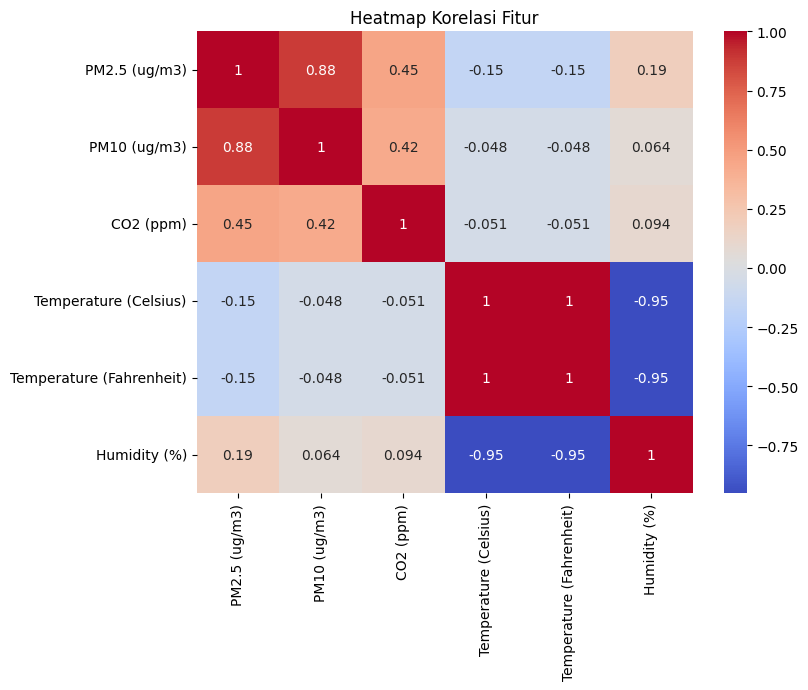

In [22]:
# --- 4. Visualisasi Korelasi ---
plt.figure(figsize=(8,6))
sns.heatmap(data_cleaned.corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur")
plt.show()

# Prepocessing

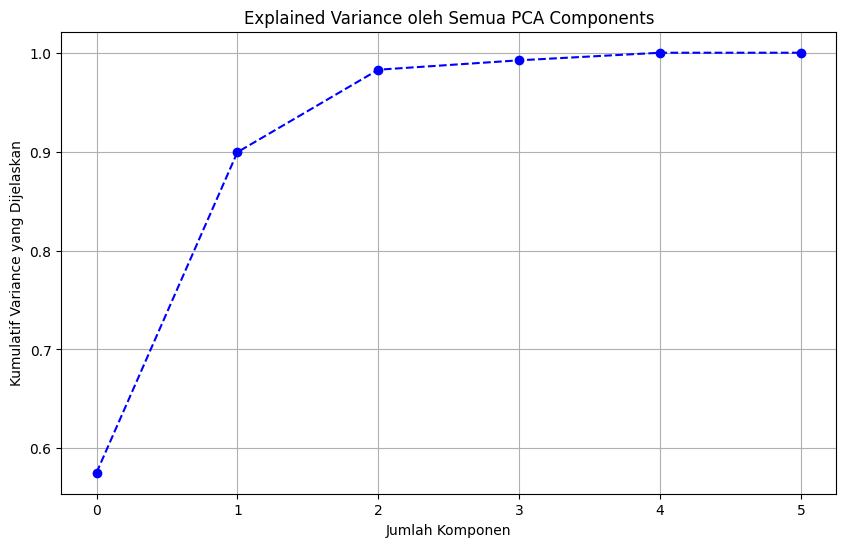

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# === 2. Split & Scaling ===
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === PCA untuk semua komponen ===
pca_full = PCA()  # tanpa n_components, supaya semua komponen dihitung
X_train_pca_full = pca_full.fit_transform(X_train_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Jumlah Komponen')
plt.ylabel('Kumulatif Variance yang Dijelaskan')
plt.title('Explained Variance oleh Semua PCA Components')
plt.grid(True)
plt.show()


In [24]:
# === 2. Split & Scaling ===
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === 3. PCA ===
pca = PCA(n_components=2)   # 3 biar bisa 2D/3D plot
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)


In [25]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())

Explained variance ratio: [0.57529647 0.32412689]
Total explained variance: 0.8994233645649559


# Clustering

In [26]:
# ==============================
# 2️⃣ DBSCAN CLUSTERING
# ==============================
eps_values = np.arange(0.2, 2.0, 0.2)
min_samples_values = range(3, 10)

best_config = None
best_score = -1  # Untuk silhouette (lebih tinggi lebih baik)

print("===== DBSCAN CLUSTERING =====")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_train_pca)
        
        # Skip jika semua titik noise (-1) atau hanya 1 cluster
        if len(set(labels)) <= 1 or (len(set(labels)) == 2 and -1 in set(labels)):
            continue
        
        try:
            sil_score = silhouette_score(X_train_pca, labels)
            dbi_score = davies_bouldin_score(X_train_pca, labels)
            
            print(f"eps={eps:.1f}, min_samples={min_samples} => "
                  f"Silhouette={sil_score:.3f}, DBI={dbi_score:.3f}")
            
            # Simpan konfigurasi terbaik berdasarkan Silhouette Score
            if sil_score > best_score:
                best_score = sil_score
                best_config = (eps, min_samples, sil_score, dbi_score)
        except Exception as e:
            print("Error:", e)
            continue

print("\n🔥 Best DBSCAN Config:")
print(f"eps={best_config[0]}, min_samples={best_config[1]}, "
      f"Silhouette={best_config[2]:.3f}, DBI={best_config[3]:.3f}")

===== DBSCAN CLUSTERING =====
eps=0.2, min_samples=3 => Silhouette=0.152, DBI=2.419
eps=0.2, min_samples=4 => Silhouette=0.130, DBI=1.998
eps=0.2, min_samples=5 => Silhouette=0.526, DBI=2.760
eps=0.2, min_samples=6 => Silhouette=0.527, DBI=3.148
eps=0.2, min_samples=7 => Silhouette=0.498, DBI=2.880
eps=0.2, min_samples=8 => Silhouette=0.498, DBI=2.301
eps=0.2, min_samples=9 => Silhouette=0.569, DBI=1.526
eps=0.6, min_samples=3 => Silhouette=0.777, DBI=2.695
eps=0.8, min_samples=3 => Silhouette=0.778, DBI=1.813
eps=1.0, min_samples=3 => Silhouette=0.772, DBI=0.656
eps=1.0, min_samples=4 => Silhouette=0.772, DBI=0.765
eps=1.6, min_samples=3 => Silhouette=0.808, DBI=1.041
eps=1.8, min_samples=3 => Silhouette=0.808, DBI=1.041

🔥 Best DBSCAN Config:
eps=1.6, min_samples=3, Silhouette=0.808, DBI=1.041


In [27]:
# --- 6. DBSCAN Clustering ---
dbscan = DBSCAN(eps=best_config[0], min_samples=best_config[1])
train_clusters = dbscan.fit_predict(X_train_pca)

# Tambahkan hasil cluster ke X_train
X_train = X_train.copy()
X_train["Cluster"] = train_clusters

print(f"✅ Number of clusters: {len(set(train_clusters)) - (1 if -1 in train_clusters else 0)}")
print(f"⚠️ Noise points: {list(train_clusters).count(-1)}")

✅ Number of clusters: 3
⚠️ Noise points: 6


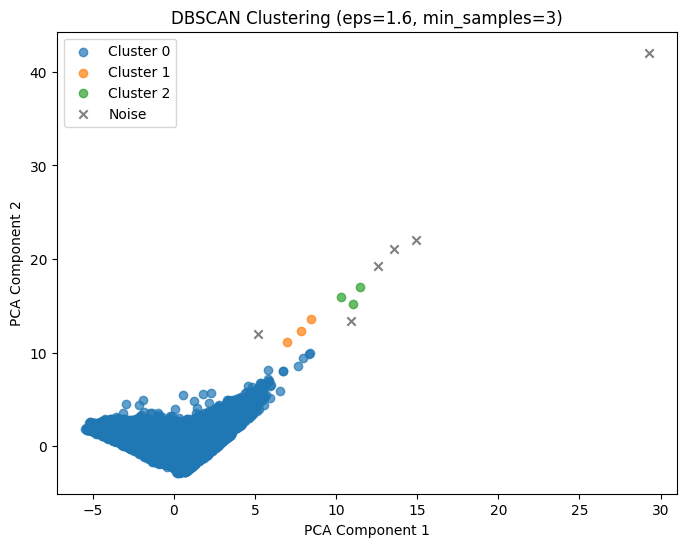

Silhouette Score: 0.817
Davies-Bouldin Index: 1.331


In [14]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train_pca)

plt.figure(figsize=(8,6))
for label in set(train_clusters):
    if label == -1:
        plt.scatter(
            X_reduced[train_clusters == label, 0],
            X_reduced[train_clusters == label, 1],
            c="k", label="Noise", alpha=0.5, marker="x"
        )
    else:
        plt.scatter(
            X_reduced[train_clusters == label, 0],
            X_reduced[train_clusters == label, 1],
            label=f"Cluster {label}", alpha=0.7
        )

plt.title(f"DBSCAN Clustering (eps={dbscan.eps}, min_samples={dbscan.min_samples})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

# %%
# --- 8. Evaluasi Clustering ---
silhouette_avg = silhouette_score(X_train_scaled, train_clusters)
db_index = davies_bouldin_score(X_train_scaled, train_clusters)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")


=== Metrics table ===
        n_clusters  total_labels                 cluster_counts  silhouette  \
method                                                                        
DBSCAN           3             4  {-1: 6, 0: 31159, 1: 3, 2: 3}    0.807922   

             dbi  calinski_harabasz  
method                               
DBSCAN  1.040593         373.312789  


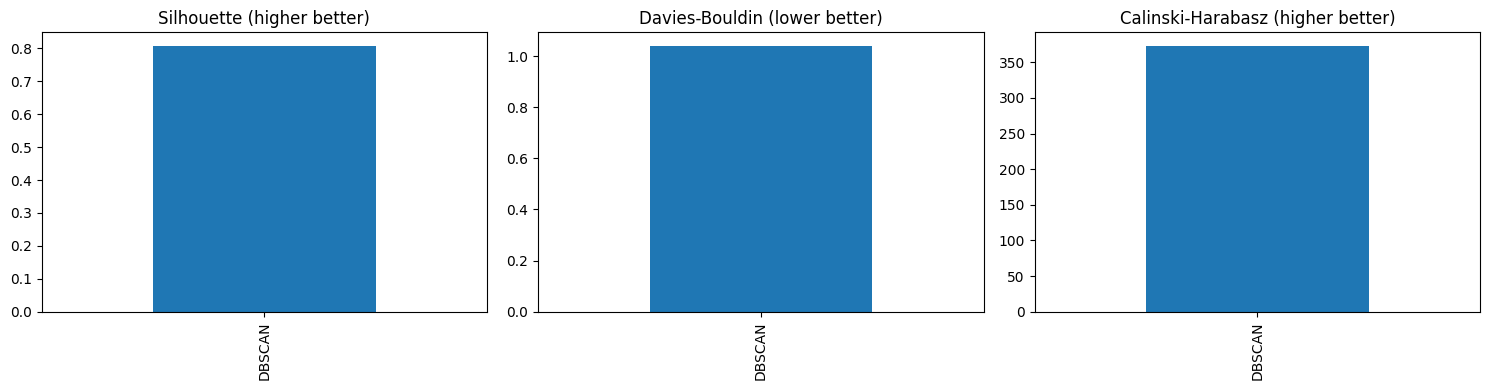

In [30]:
# === Kode: bandingkan metrik clustering secara rapi ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# --- Pastikan labels dan fitur ada ---
# labels_kmeans: hasil predict KMeans pada X_train_pca
# labels_dbscan: hasil predict DBSCAN pada X_train_pca (noise -> -1)
# labels_ahc: hasil predict Agglomerative pada X_train_scaled (atau X_train_pca jika ingin konsisten)
# X_train_pca: data diproyeksikan PCA 2D (untuk visual / perhitungan yang sama)
# X_train_scaled: data ter-scaling (dipakai kalau labels dibuat dari scaled)

# Fungsi bantu: cek validitas cluster sebelum hitung metrik

# === DBSCAN ===
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.6, min_samples=3)
labels_dbscan = dbscan.fit_predict(X_train_pca)

def valid_for_metrics(labels):
    unique = set(labels)
    # jika DBSCAN, noise = -1; kita masih butuh minimal 2 cluster non-noise
    n_non_noise = len([u for u in unique if u != -1])
    # silhouette requires at least 2 clusters (excluding noise) and more than 1 sample per cluster
    # we'll accept if there are >=2 non-noise clusters and total unique labels >=2
    return (n_non_noise >= 2) and (len(unique) >= 2)

def compute_metrics(name, labels, X_for_metrics):
    row = {"method": name}
    # cluster sizes
    clusters, counts = np.unique(labels, return_counts=True)
    row["n_clusters"] = len([c for c in clusters if c != -1])  # non-noise cluster count
    row["total_labels"] = len(clusters)
    row["cluster_counts"] = dict(zip(clusters.astype(int).tolist(), counts.tolist()))
    
    if not valid_for_metrics(labels):
        # tidak cukup cluster valid untuk menghitung silhouette
        row["silhouette"] = np.nan
        row["dbi"] = np.nan
        row["calinski_harabasz"] = np.nan
        row["note"] = "Not enough valid clusters (or mostly noise)."
        return row
    
    # silhouette: gunakan hanya pada titik non-noise (jika noise ada)
    if -1 in labels:
        mask = (labels != -1)
        labels_for_sil = labels[mask]
        X_for_sil = X_for_metrics[mask]
    else:
        labels_for_sil = labels
        X_for_sil = X_for_metrics
    
    # edge-case: silhouette_score requires at least 2 labels and each label must have >1 sample
    # sklearn will raise if any cluster has size 1; we will catch and set nan with note.
    try:
        row["silhouette"] = silhouette_score(X_for_sil, labels_for_sil)
    except Exception as e:
        row["silhouette"] = np.nan
        row["note_silhouette_error"] = str(e)
    
    try:
        # DBI can be computed with all labels including noise (but -1 treated like cluster)
        row["dbi"] = davies_bouldin_score(X_for_metrics, labels)
    except Exception as e:
        row["dbi"] = np.nan
        row["note_dbi_error"] = str(e)
    
    try:
        # Calinski-Harabasz requires at least 2 clusters (no requirement to remove noise)
        row["calinski_harabasz"] = calinski_harabasz_score(X_for_metrics, labels)
    except Exception as e:
        row["calinski_harabasz"] = np.nan
        row["note_ch_error"] = str(e)
    
    return row

# --- Hitung untuk tiap metode (sesuaikan variable names jika berbeda) ---
results = []
results.append(compute_metrics("DBSCAN", labels_dbscan, X_train_pca))
# results.append(compute_metrics("DBSCAN", labels_dbscan, X_train_pca))
# # Untuk AHC: jika kamu membangun labels_ahc dari X_train_scaled, tetap gunakan X_train_scaled,
# # tapi demi konsistensi visual kita bisa juga memberikan X_train_pca. Gunakan yang sesuai.
# results.append(compute_metrics("Agglomerative", labels_ahc, X_train_pca))

df_metrics = pd.DataFrame(results).set_index("method")
# Kolom cluster_counts jadi string agar tampil rapi
df_metrics["cluster_counts"] = df_metrics["cluster_counts"].apply(lambda d: str(d))

print("=== Metrics table ===")
print(df_metrics[["n_clusters","total_labels","cluster_counts","silhouette","dbi","calinski_harabasz"]])

# --- Plot perbandingan metrik (bar chart) ---
plot_df = df_metrics[["silhouette","dbi","calinski_harabasz"]].copy()
plot_df = plot_df.astype(float)

fig, ax = plt.subplots(1,3, figsize=(15,4))
plot_df["silhouette"].plot(kind="bar", ax=ax[0], title="Silhouette (higher better)")
plot_df["dbi"].plot(kind="bar", ax=ax[1], title="Davies-Bouldin (lower better)")
plot_df["calinski_harabasz"].plot(kind="bar", ax=ax[2], title="Calinski-Harabasz (higher better)")
for a in ax:
    a.set_xlabel("")
plt.tight_layout()
plt.show()


AQI_Category   Good  Moderate  Poor  Satisfactory  Severe  Very Poor
Cluster                                                             
-1                0         0     0             0       6          0
 0            12661      4668  1258         11424     265        883
 1                0         0     0             0       2          1
 2                0         0     0             0       3          0


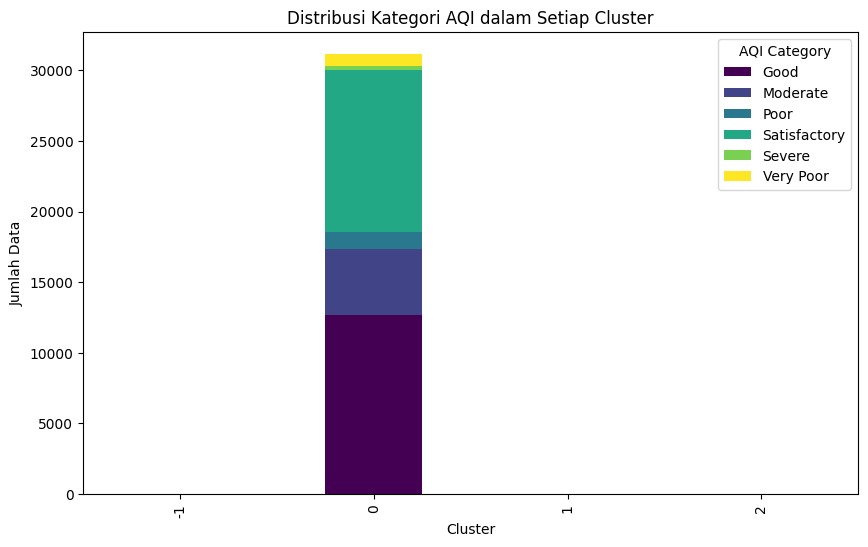

In [28]:
# --- 9. Hitung AQI (Linear Segmentation) ---

# Tabel breakpoints (Bmin, Bmax, Imin, Imax)
breakpoints = {
    "PM2.5": [(0, 30, 0, 50),
              (31, 60, 51, 100),
              (61, 90, 101, 200),
              (91, 120, 201, 300),
              (121, 250, 301, 400)],
    
    "PM10": [(0, 50, 0, 50),
             (51, 100, 51, 100),
             (101, 250, 101, 200),
             (251, 350, 201, 300),
             (351, 430, 301, 400)]
    
    # Contoh adaptasi CO2 (ppm)
}

def calculate_sub_index(pollutant, concentration):
    for (Bmin, Bmax, Imin, Imax) in breakpoints[pollutant]:
        if Bmin <= concentration <= Bmax:
            return ((Imax - Imin) / (Bmax - Bmin)) * (concentration - Bmin) + Imin
    return np.nan

def calculate_aqi_linear(row):
    sub_pm25 = calculate_sub_index("PM2.5", row["PM2.5 (ug/m3)"])
    sub_pm10 = calculate_sub_index("PM10", row["PM10 (ug/m3)"])
    return max(sub_pm25, sub_pm10)

def categorize_aqi(value):
    if value <= 50: return "Good"
    elif value <= 100: return "Satisfactory"
    elif value <= 200: return "Moderate"
    elif value <= 300: return "Poor"
    elif value <= 400: return "Very Poor"
    else: return "Severe"

# Tambahkan ke dataframe
X_train["AQI_Value"] = X_train.apply(calculate_aqi_linear, axis=1)
X_train["AQI_Category"] = X_train["AQI_Value"].apply(categorize_aqi)

# %%
# --- 10. Crosstab Cluster vs AQI Category ---
crosstab = pd.crosstab(X_train["Cluster"], X_train["AQI_Category"])
print(crosstab)

crosstab.plot(kind="bar", stacked=True, figsize=(10,6), colormap="viridis")
plt.title("Distribusi Kategori AQI dalam Setiap Cluster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Data")
plt.legend(title="AQI Category")
plt.show()